Using MODELS_DIR: /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models

Ablation results (ΔNLL < 0 ⇒ added covariate helps):

   feature variant base_rung candidate_rung  n_pairs  delta_nll_mean  delta_nll_ci95_lo  delta_nll_ci95_hi  relative_improvement_percent  sig_nll  delta_top1_mean  delta_top1_ci95_lo  delta_top1_ci95_hi  sig_top1
  Day Type     b1h        R1             R4    48781        0.000655       5.760116e-04           0.000736                     -0.149348    False     0.000000e+00        0.000000e+00            0.000000     False
Employment     b1h        R1             R3    48781       -0.000508      -6.501688e-04          -0.000381                      0.115818     True     0.000000e+00        0.000000e+00            0.000000     False
   HH Size     b1h        R1             R5    48781        0.000672       5.341892e-04           0.000802                     -0.153271    False     0.000000e+00        0.000000e+00            0.000000     False

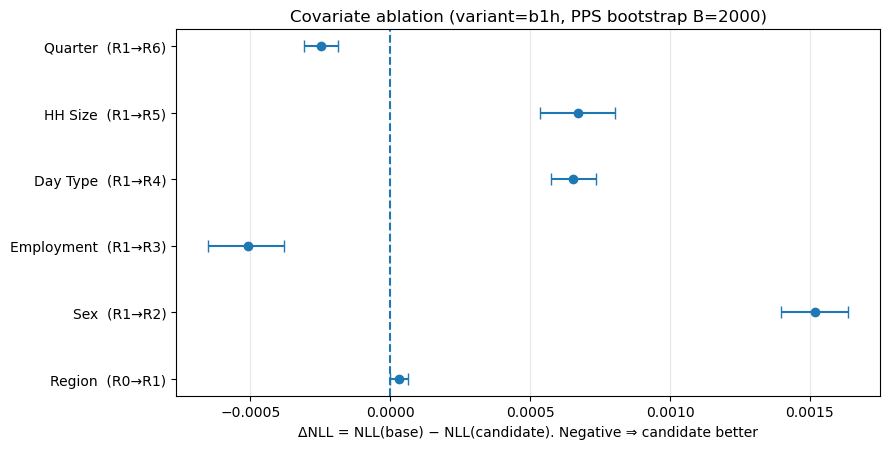

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/forest_delta_nll_covariates_b1h.png


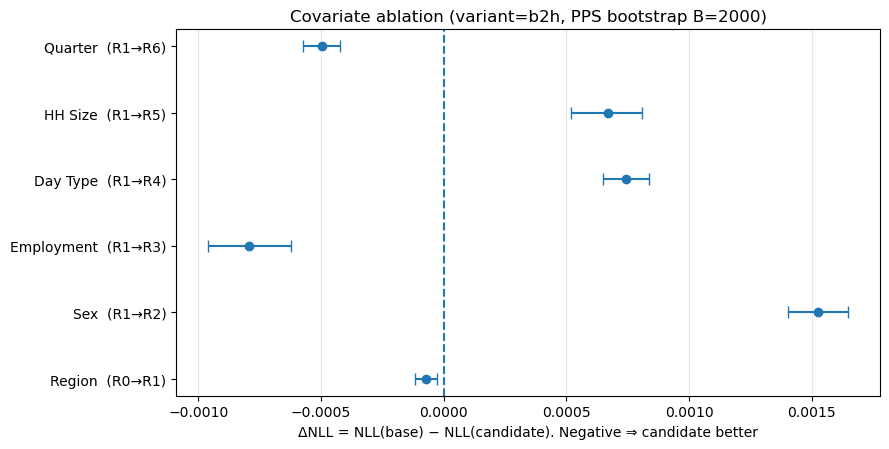

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/forest_delta_nll_covariates_b2h.png

Feature ranking by marginal ΔNLL (most helpful first) per variant:

[b1h]
 1. Employment  ΔNLL=-0.000508  95%CI[-0.000650,-0.000381]  rel=+0.116% *
 2. Quarter     ΔNLL=-0.000245  95%CI[-0.000307,-0.000187]  rel=+0.056% *
 3. Region      ΔNLL=+0.000031  95%CI[+0.000001,+0.000063]  rel=-0.007%
 4. Day Type    ΔNLL=+0.000655  95%CI[+0.000576,+0.000736]  rel=-0.149%
 5. HH Size     ΔNLL=+0.000672  95%CI[+0.000534,+0.000802]  rel=-0.153%
 6. Sex         ΔNLL=+0.001517  95%CI[+0.001395,+0.001636]  rel=-0.346%

[b2h]
 1. Employment  ΔNLL=-0.000792  95%CI[-0.000960,-0.000622]  rel=+0.186% *
 2. Quarter     ΔNLL=-0.000497  95%CI[-0.000574,-0.000422]  rel=+0.117% *
 3. Region      ΔNLL=-0.000071  95%CI[-0.000119,-0.000028]  rel=+0.017% *
 4. HH Size     ΔNLL=+0.000671  95%CI[+0.000521,+0.000807]  rel=-0.157%
 5. Day Type    ΔNLL=+0.000745  95%CI[+0.000649,+0.000835

In [1]:
# === Covariate Ablation (R0→R6; R6 = Region+Quarter) ===
# This cell is self-contained and safe to paste anywhere below your existing loaders;
# if your notebook already defined MODELS_DIR or metrics_map, we reuse them.

from __future__ import annotations
import os, json
from pathlib import Path
from typing import Optional, Dict, Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- paths / discovery ----------------
def _guess_models_dir() -> Path:
    # use MODELS_DIR 
    try:
        return Path(MODELS_DIR).resolve()  # type: ignore
    except Exception:
        pass
    here = Path.cwd().resolve()
    candidates = [
        here / "atus_analysis" / "data" / "models",
        here / ".." / "atus_analysis" / "data" / "models",
        here / ".." / "data" / "models",
        here / "data" / "models",
    ]
    # walk up a few levels too
    up = here
    for _ in range(4):
        candidates.append(up / "atus_analysis" / "data" / "models")
        up = up.parent
    env = os.environ.get("ATUS_MODELS_DIR")
    if env:
        candidates.insert(0, Path(env))
    for p in candidates:
        if p.exists():
            return p.resolve()
    raise FileNotFoundError("Could not locate models directory; set ATUS_MODELS_DIR or define MODELS_DIR.")

MODELS_DIR = _guess_models_dir()
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)
print("Using MODELS_DIR:", MODELS_DIR)

# ---------------- load helpers ----------------
def _metrics_path(run_dir: Path, variant: str) -> Optional[Path]:
    # Prefer per-variant file, fall back to generic
    p1 = run_dir / f"test_case_metrics_{variant}.parquet"
    if p1.exists(): return p1
    p2 = run_dir / "test_case_metrics.parquet"
    return p2 if p2.exists() else None

def load_metrics(run_name: str, variant: str) -> pd.DataFrame:
    p = _metrics_path(MODELS_DIR / run_name, variant)
    if p is None:
        raise FileNotFoundError(f"Missing metrics for {run_name} ({variant}) under {MODELS_DIR/run_name}")
    df = pd.read_parquet(p).copy()
    needed = {"TUCASEID", "nll_weighted", "top1_correct_weight", "weight_total"}
    miss = needed - set(df.columns)
    if miss:
        raise KeyError(f"{p} missing columns: {sorted(miss)}")
    # convenience
    df["nll"] = df["nll_weighted"] / df["weight_total"]
    df["top1_acc"] = df["top1_correct_weight"] / df["weight_total"]
    return df[["TUCASEID","nll_weighted","top1_correct_weight","weight_total","nll","top1_acc"]].copy()

# Optional: reuse metrics already loaded upstream
try:
    _preloaded = isinstance(metrics_map, dict) and len(metrics_map) > 0  # type: ignore
except NameError:
    _preloaded = False

def get_metrics(run_name: str, variant: str) -> pd.DataFrame:
    # If your notebook already built a dict {(rung,variant): df} called metrics_map, use it
    if _preloaded:
        try:
            return metrics_map[(run_name, variant)].copy()  # type: ignore
        except Exception:
            pass
    return load_metrics(run_name, variant)

# ---------------- PPS bootstrap ----------------
def pps_bootstrap_delta(dfA: pd.DataFrame, dfB: pd.DataFrame, B: int = 2000, seed: int = 2025):
    """
    Align respondents on TUCASEID; sample TUCASEID with replacement using PPS ∝ weight_total in A when valid, else uniform.
    Return (samples_df, summary_dict)
    """
    df = dfA.merge(dfB, on="TUCASEID", suffixes=("_A","_B")).copy()
    # keep only positive weights
    df = df[(df["weight_total_A"]>0) & (df["weight_total_B"]>0)].reset_index(drop=True)
    if len(df)==0:
        raise ValueError("No aligned respondents with positive weights in A and B.")

    wA = df["weight_total_A"].astype(float)
    use_pps = np.isfinite(wA.sum()) and (wA.sum()>0) and (wA>=0).all()
    probs = (wA / wA.sum()).values if use_pps else None

    rng = np.random.RandomState(seed)
    draws = []
    n = len(df)
    for _ in range(B):
        idx = (rng.choice(np.arange(n), size=n, replace=True, p=probs)
               if probs is not None else rng.randint(0, n, n))
        s = df.iloc[idx]
        WA = float(s["weight_total_A"].sum()); WB = float(s["weight_total_B"].sum())
        nllA = float(s["nll_weighted_A"].sum()) / WA
        nllB = float(s["nll_weighted_B"].sum()) / WB
        topA = float(s["top1_correct_weight_A"].sum()) / WA
        topB = float(s["top1_correct_weight_B"].sum()) / WB
        draws.append({"nllA": nllA, "nllB": nllB, "delta": nllA - nllB,
                      "topA": topA, "topB": topB, "delta_top": topA - topB})
    samp = pd.DataFrame(draws)
    ci_lo, ci_hi = np.percentile(samp["delta"], [0.5, 99.5])#[2.5, 97.5])
    ci_lo_t, ci_hi_t = np.percentile(samp["delta_top"], [0.5, 99.5]) #[2.5, 97.5])
    d_mean = float(samp["delta"].mean())
    rel = (-d_mean / float(samp["nllA"].mean()))*100.0 if float(samp["nllA"].mean())!=0 else np.nan

    summary = dict(
        B=B, n_pairs=int(n),
        delta_nll_mean=d_mean,
        delta_nll_ci95_lo=float(ci_lo), delta_nll_ci95_hi=float(ci_hi),
        nllA_mean=float(samp["nllA"].mean()), nllB_mean=float(samp["nllB"].mean()),
        relative_improvement_percent=rel,
        delta_top1_mean=float(samp["delta_top"].mean()),
        delta_top1_ci95_lo=float(ci_lo_t), delta_top1_ci95_hi=float(ci_hi_t),
        note="ΔNLL = NLL(base) − NLL(candidate); negative favours candidate",
        resampling="PPS by weight_total_A; fallback uniform"
    )
    return samp, summary

# ---------------- ablation setup (single-covariate additions on top of Region) ----------------
VARIANTS = ("b1h","b2h")   # routing-only and routing+hazard
B = 2000                   # bootstrap draws (tune for speed/precision)
SEED = 2025

ABLATION = [
    ("Region",   "R0", "R1"),
    ("Sex",      "R1", "R2"),
    ("Employment","R1","R3"),
    ("Day Type", "R1", "R4"),
    ("HH Size",  "R1", "R5"),
    ("Quarter",  "R1", "R6"),  # UPDATED: R6 is Region + Quarter
]

# ---------------- run & summarize ----------------
def run_covariate_ablation() -> pd.DataFrame:
    rows = []
    for variant in VARIANTS:
        for feat, base_rung, cand_rung in ABLATION:
            try:
                A = get_metrics(base_rung, variant).rename(columns=lambda c: c+"_A" if c not in ["TUCASEID"] else c)
                Bm = get_metrics(cand_rung, variant).rename(columns=lambda c: c+"_B" if c not in ["TUCASEID"] else c)
            except Exception as e:
                print(f"[SKIP] {feat} {base_rung}->{cand_rung} ({variant}): {e}")
                continue
            _, summ = pps_bootstrap_delta(A, Bm, B=B, seed=SEED)
            rows.append({
                "feature": feat, "variant": variant,
                "base_rung": base_rung, "candidate_rung": cand_rung, **summ
            })
    df = pd.DataFrame(rows)
    if len(df):
        df["sig_nll"] = df["delta_nll_ci95_hi"] < 0.0
        df["sig_top1"] = (df["delta_top1_ci95_lo"]>0.0) | (df["delta_top1_ci95_hi"]<0.0)
    return df.sort_values(["variant","feature"]).reset_index(drop=True)

ab_df = run_covariate_ablation()

print("\nAblation results (ΔNLL < 0 ⇒ added covariate helps):\n")
if len(ab_df):
    show_cols = ["feature","variant","base_rung","candidate_rung","n_pairs",
                 "delta_nll_mean","delta_nll_ci95_lo","delta_nll_ci95_hi",
                 "relative_improvement_percent","sig_nll",
                 "delta_top1_mean","delta_top1_ci95_lo","delta_top1_ci95_hi","sig_top1"]
    print(ab_df[show_cols].to_string(index=False))
else:
    print("No results produced. Check that metrics exist for the rungs and variants.")

# Save CSV + manifest
if len(ab_df):
    OUT_DIR.mkdir(exist_ok=True)
    out_csv = OUT_DIR / "covariate_ablation_results.csv"
    ab_df.to_csv(out_csv, index=False)
    with open(OUT_DIR / "covariate_ablation_manifest.json","w") as f:
        json.dump({"models_dir": str(MODELS_DIR),
                   "pairs": ABLATION, "variants": VARIANTS,
                   "bootstrap_B": B, "seed": SEED,
                   "csv": str(out_csv.resolve())}, f, indent=2)
    print(f"\nSaved: {out_csv.resolve()}")

# ---------------- forest plots per variant ----------------
plt.rcParams.update({"font.size": 10})
for variant in VARIANTS:
    dfv = ab_df[ab_df["variant"]==variant].copy()
    if not len(dfv):
        continue
    # keep declared order
    order = [f for (f,_,_) in ABLATION if f in set(dfv["feature"])]
    dfv = dfv.set_index("feature").loc[order].reset_index()

    xs  = dfv["delta_nll_mean"].to_numpy()
    xlo = xs - dfv["delta_nll_ci95_lo"].to_numpy()
    xhi = dfv["delta_nll_ci95_hi"].to_numpy() - xs
    y   = np.arange(len(dfv))

    plt.figure(figsize=(9, max(3, 0.6*len(y)+1)))
    plt.errorbar(xs, y, xerr=[xlo, xhi], fmt='o', capsize=4)
    plt.axvline(0, linestyle='--')
    yt = [f"{f}  ({a}→{c})" for f,a,c in zip(dfv["feature"], dfv["base_rung"], dfv["candidate_rung"])]
    plt.yticks(y, yt)
    plt.xlabel("ΔNLL = NLL(base) − NLL(candidate). Negative ⇒ candidate better")
    plt.title(f"Covariate ablation (variant={variant}, PPS bootstrap B={B})")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    out_png = OUT_DIR / f"forest_delta_nll_covariates_{variant}.png"
    plt.savefig(out_png, dpi=300)
    plt.show()
    print(f"Saved plot → {out_png.resolve()}")

# ---------------- quick ranking printout ----------------
if len(ab_df):
    print("\nFeature ranking by marginal ΔNLL (most helpful first) per variant:")
    for variant in VARIANTS:
        dfv = ab_df[ab_df["variant"]==variant].sort_values("delta_nll_mean")  # more negative is better
        if not len(dfv): 
            continue
        print(f"\n[{variant}]")
        for i, r in enumerate(dfv.itertuples(index=False), 1):
            star = " *" if r.sig_nll else ""
            print(f"{i:2d}. {r.feature:10s}  ΔNLL={r.delta_nll_mean:+.6f}  95%CI[{r.delta_nll_ci95_lo:+.6f},{r.delta_nll_ci95_hi:+.6f}]  rel={r.relative_improvement_percent:+.3f}%{star}")


Using MODELS_DIR: /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models
Rungs (size=#covariates):
rung                                          covariates  size
  R0                                                         0
  R1                                              region     1
 R10                                            day_type     1
 R11                                        hh_size_band     1
 R12                                             quarter     1
  R2                                          region,sex     2
  R3                                   employment,region     2
  R4                                     day_type,region     2
  R5                                 hh_size_band,region     2
  R6                                      quarter,region     2
  R7 day_type,employment,hh_size_band,quarter,region,sex     6
  R8                                                 sex     1
  R9                                          employment     

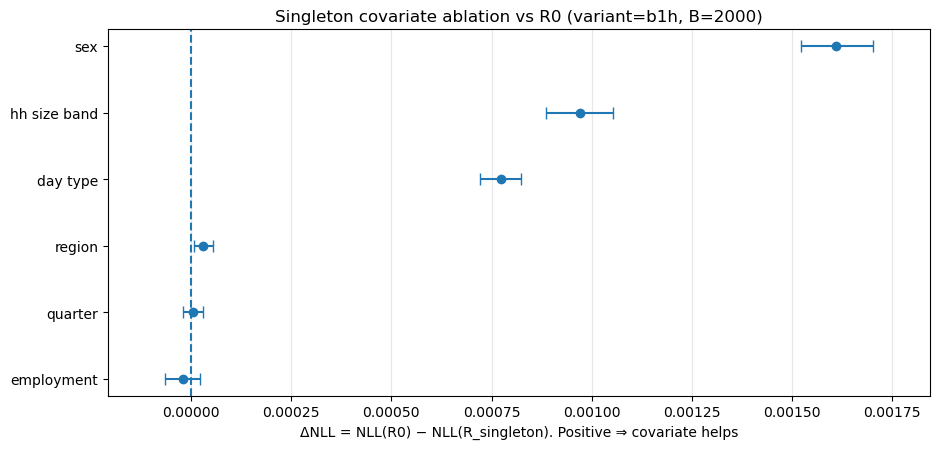

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/forest_singleton_vs_R0_b1h.png


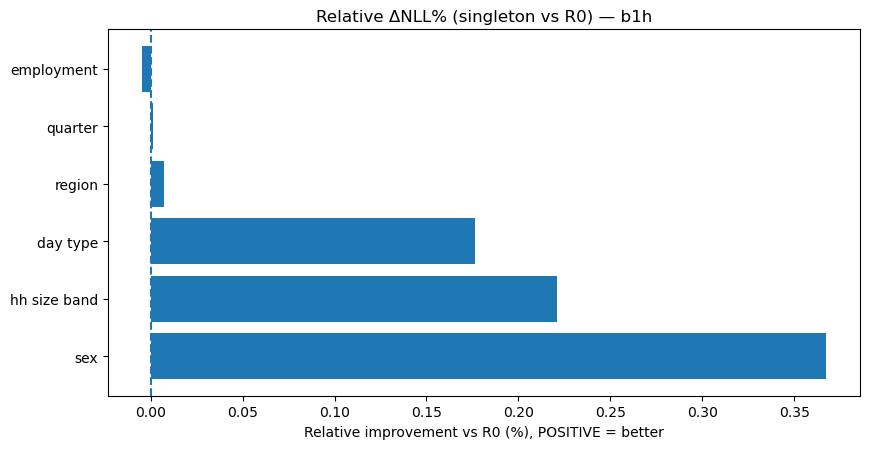

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/relative_improvement_singleton_b1h.png


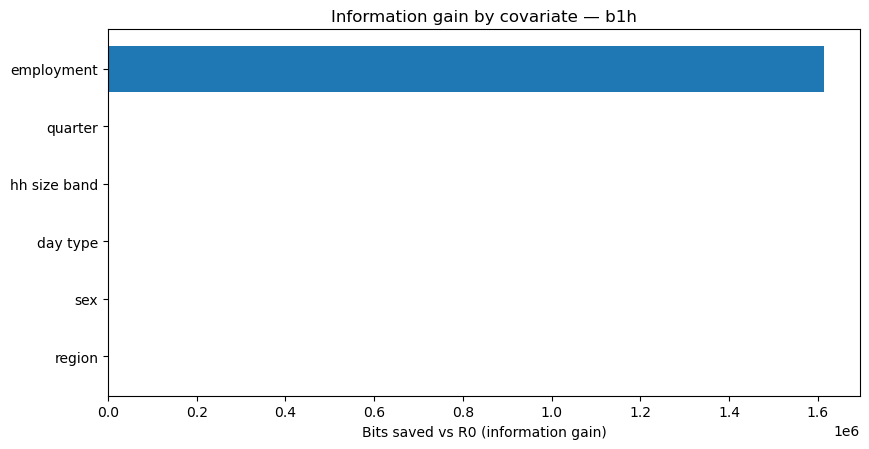

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/bits_saved_singleton_b1h.png


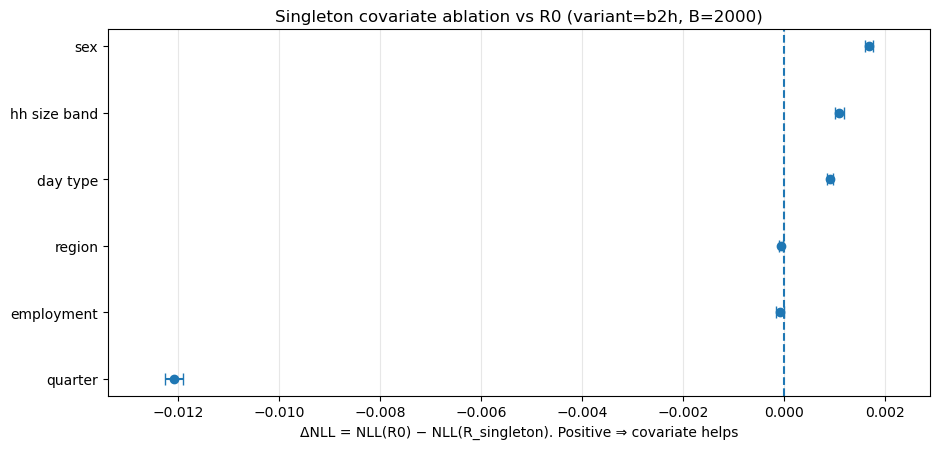

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/forest_singleton_vs_R0_b2h.png


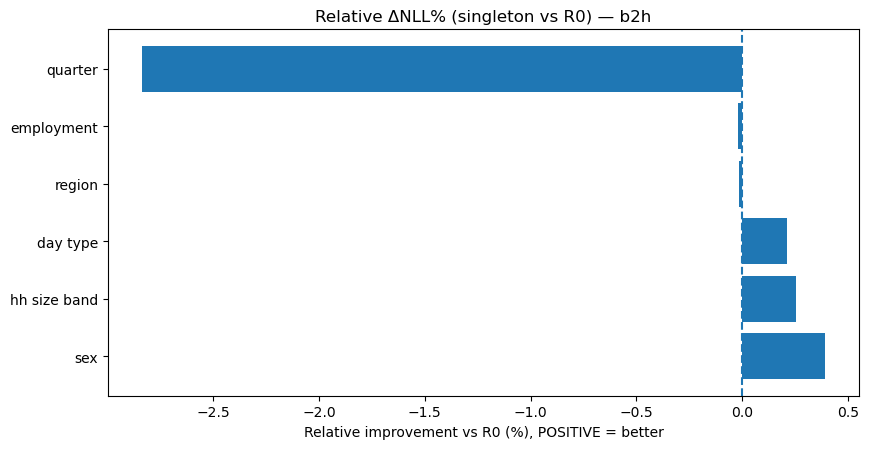

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/relative_improvement_singleton_b2h.png


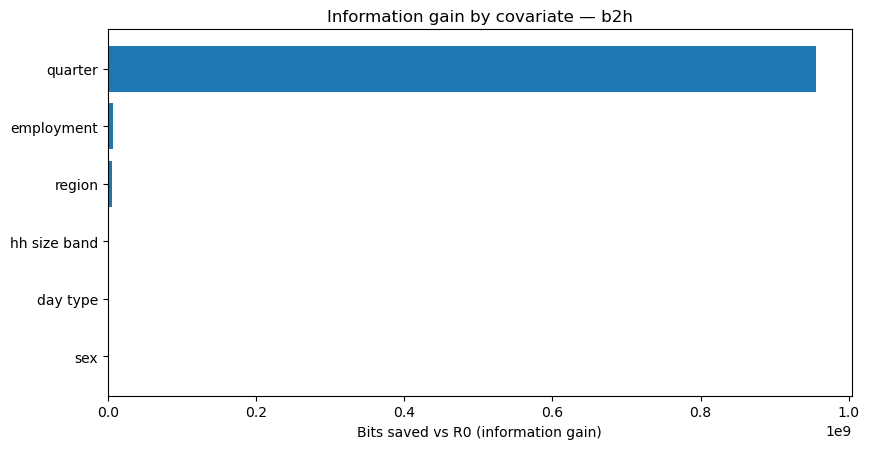

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/bits_saved_singleton_b2h.png


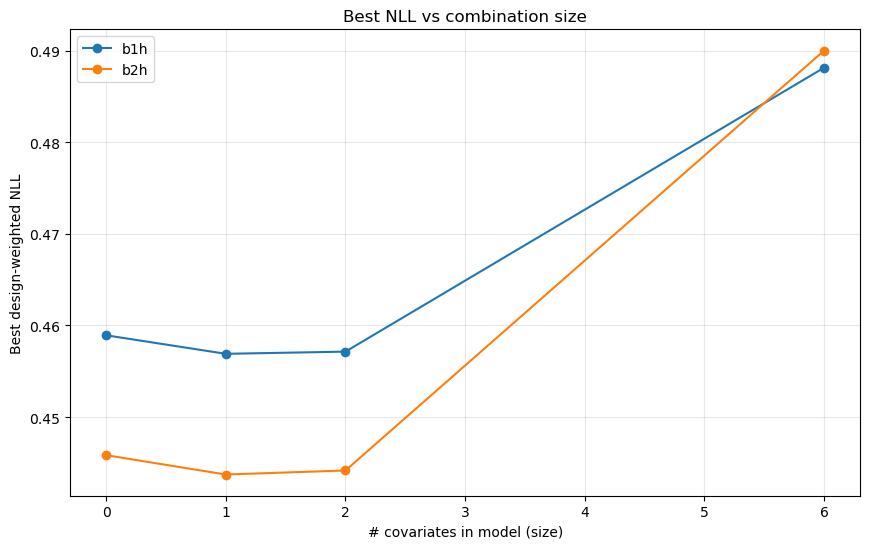

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/best_by_size_curves.png


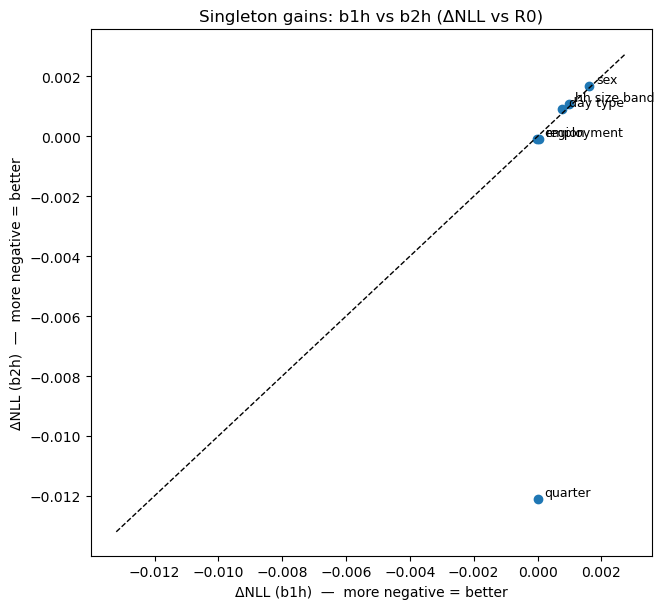

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/scatter_b1h_vs_b2h_singleton.png


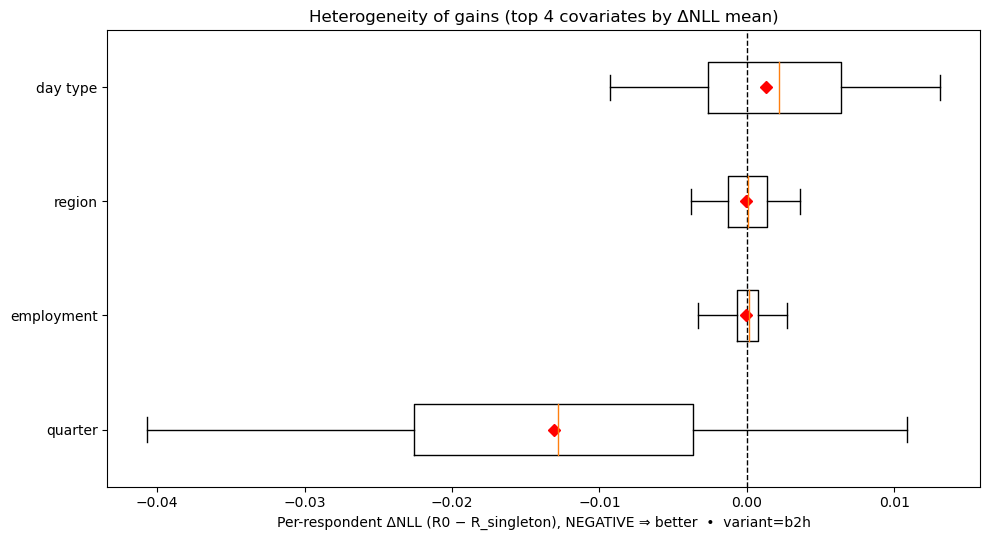

Saved plot → /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/notebooks/outputs/case_delta_boxplots_top4_b2h.png


True

In [10]:
# === Standalone Covariate Importance vs R0 + Best-by-Size + Deep-Dive Plots (b1h & b2h) ===
# (Fixes)
# - Adds explicit "better_*" and "sig_*" booleans for NLL and Top1.
# - Relative-improvement stays POSITIVE = better (no manual negation in plotting).
# - Forest x-label restored to NEGATIVE ⇒ better (matches Δ definition here).
# - Fixed [SKIP] print bug.
# - Clarified per-respondent boxplot x-label.

from __future__ import annotations
import os, json, math
from pathlib import Path
from typing import Optional, Dict, Tuple, List, Set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- User-config ----------------
VARIANTS = ("b1h","b2h")
B = 2000
SEED = 2025
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

# Rung→spec (update as needed)
RUNG_SPECS = {
    "R0": "none",
    "R1": "region",
    "R2": "region,sex",
    "R3": "region,employment",
    "R4": "region,day_type",
    "R5": "region,hh_size_band",
    "R6": "region,quarter",
    "R7": "employment,day_type,hh_size_band,sex,region,quarter",
    "R8": "sex",
    "R9": "employment",
    "R10": "day_type",
    "R11": "hh_size_band",
    "R12": "quarter",
}

# Singletons of interest vs R0
COV_SINGLETONS = {
    "region": "R1",
    "sex": "R8",
    "employment": "R9",
    "day_type": "R10",
    "hh_size_band": "R11",
    "quarter": "R12",
}

# ---------------- Minimal loaders ----------------
def _guess_models_dir() -> Path:
    try:
        return Path(MODELS_DIR).resolve()  # reuse if defined upstream
    except Exception:
        pass
    here = Path.cwd().resolve()
    env = os.environ.get("ATUS_MODELS_DIR")
    if env and Path(env).exists():
        return Path(env).resolve()
    for p in [
        here / "atus_analysis" / "data" / "models",
        here / ".." / "atus_analysis" / "data" / "models",
        here / ".." / "data" / "models",
        here / "data" / "models",
    ]:
        if p.exists(): return p.resolve()
    raise FileNotFoundError("Set ATUS_MODELS_DIR or define MODELS_DIR upstream.")

try:
    MODELS_DIR = Path(MODELS_DIR)  # type: ignore
except Exception:
    MODELS_DIR = _guess_models_dir()

def _metrics_path(run_dir: Path, variant: str) -> Optional[Path]:
    p = run_dir / f"test_case_metrics_{variant}.parquet"
    if p.exists(): return p
    q = run_dir / "test_case_metrics.parquet"
    return q if q.exists() else None

def get_metrics(run_name: str, variant: str) -> pd.DataFrame:
    p = _metrics_path(MODELS_DIR / run_name, variant)
    if p is None:
        raise FileNotFoundError(f"Missing metrics for {run_name} ({variant}) under {MODELS_DIR/run_name}")
    df = pd.read_parquet(p).copy()
    need = {"TUCASEID","nll_weighted","top1_correct_weight","weight_total"}
    miss = need - set(df.columns)
    if miss:
        raise KeyError(f"{p} missing columns: {sorted(miss)}")
    df["nll"] = df["nll_weighted"] / df["weight_total"]
    df["top1_acc"] = df["top1_correct_weight"] / df["weight_total"]
    return df[["TUCASEID","nll_weighted","top1_correct_weight","weight_total","nll","top1_acc"]].copy()

# ---------------- Bootstrap ΔNLL (paired, PPS by A weights) ----------------
def pps_bootstrap_delta(dfA: pd.DataFrame, dfB: pd.DataFrame, B: int = 2000, seed: int = 2025):
    """
    Align on TUCASEID; sample respondents with replacement using PPS ∝ weight_total in A (R0).
    Returns (samples_df, summary_dict).

    Convention:
      ΔNLL = NLL(A) − NLL(B)  (NEGATIVE ⇒ candidate better).
      ΔTop1 = Top1(A) − Top1(B)  (NEGATIVE ⇒ candidate better, since lower error / higher acc).
    """
    df = dfA.merge(dfB, on="TUCASEID", suffixes=("_A","_B")).copy()
    df = df[(df["weight_total_A"]>0) & (df["weight_total_B"]>0)].reset_index(drop=True)
    if len(df)==0:
        raise ValueError("No aligned respondents with positive weights in A and B.")
    wA = df["weight_total_A"].astype(float)
    use_pps = np.isfinite(wA.sum()) and (wA.sum()>0) and (wA>=0).all()
    p = (wA / wA.sum()).values if use_pps else None

    rng = np.random.RandomState(seed)
    rows = []
    n = len(df)
    for _ in range(B):
        idx = (rng.choice(np.arange(n), size=n, replace=True, p=p)
               if p is not None else rng.randint(0, n, n))
        s = df.iloc[idx]
        WA = float(s["weight_total_A"].sum()); WB = float(s["weight_total_B"].sum())
        if WA <= 0 or WB <= 0:
            continue
        nllA = float(s["nll_weighted_A"].sum()) / WA
        nllB = float(s["nll_weighted_B"].sum()) / WB
        topA = float(s["top1_correct_weight_A"].sum()) / WA
        topB = float(s["top1_correct_weight_B"].sum()) / WB
        rows.append({"nllA": nllA, "nllB": nllB, "delta": nllA - nllB,
                     "topA": topA, "topB": topB, "delta_top": topA - topB})
    samp = pd.DataFrame(rows)
    if not len(samp):
        raise ValueError("Bootstrap produced no valid draws (check weights/metrics).")

    lo, hi    = np.percentile(samp["delta"],     [2.5, 97.5])
    lo_t, hi_t= np.percentile(samp["delta_top"], [2.5, 97.5])
    d_mean    = float(samp["delta"].mean())
    t_mean    = float(samp["delta_top"].mean())

    denom = float(samp["nllA"].mean())
    rel = (-d_mean / denom)*100.0 if denom != 0 else np.nan  # POSITIVE = better

    # Explicit flags
    better_nll          = d_mean < 0.0
    better_nll_sig_imp  = hi < 0.0                   # significant improvement
    better_nll_sig_any  = (hi < 0.0) or (lo > 0.0)   # two-sided: CI excludes 0

    better_top          = t_mean < 0.0               # same sign rule for Top-1 deltas
    better_top_sig_imp  = hi_t < 0.0
    better_top_sig_any  = (hi_t < 0.0) or (lo_t > 0.0)

    return samp, dict(
        B=B, n_pairs=int(n),
        delta_nll_mean=d_mean, delta_nll_ci95_lo=float(lo), delta_nll_ci95_hi=float(hi),
        nllA_mean=float(samp["nllA"].mean()), nllB_mean=float(samp["nllB"].mean()),
        relative_improvement_percent=rel,   # POSITIVE = better
        delta_top1_mean=t_mean, delta_top1_ci95_lo=float(lo_t), delta_top1_ci95_hi=float(hi_t),
        note="ΔNLL = NLL(R0) − NLL(R_singleton) (negative favours singleton); ΔTop1 same sign rule.",
        resampling="PPS by weight_total of R0; fallback uniform",
        better_nll=better_nll,
        better_nll_sig95_improve=better_nll_sig_imp,
        better_nll_sig95_any=better_nll_sig_any,
        better_top1=better_top,
        better_top1_sig95_improve=better_top_sig_imp,
        better_top1_sig95_any=better_top_sig_any
    )

# ---------------- Helpers: parse rung specs and size ----------------
def parse_cov_set(spec: str) -> Set[str]:
    if spec is None: return set()
    toks = [t.strip().lower() for t in spec.split(",") if t.strip()]
    toks = [t for t in toks if t not in {"none"}]
    return set(toks)

RUNG_SETS: Dict[str, Set[str]] = {r: parse_cov_set(s) for r, s in RUNG_SPECS.items()}
RUNG_SIZES: Dict[str, int] = {r: len(v) for r, v in RUNG_SETS.items()}

# Inventory table
inventory_rows = [{"rung": r, "covariates": ",".join(sorted(list(RUNG_SETS[r]))), "size": RUNG_SIZES[r]}
                  for r in sorted(RUNG_SPECS.keys())]
inventory_df = pd.DataFrame(inventory_rows)
inventory_df.to_csv(OUT_DIR / "rung_sizes.csv", index=False)
print("Using MODELS_DIR:", MODELS_DIR)
print("Rungs (size=#covariates):")
print(inventory_df.to_string(index=False))

# ---------------- 1) Singleton ablation vs R0 ----------------
def singleton_ablation_vs_R0() -> pd.DataFrame:
    results = []
    for variant in VARIANTS:
        try:
            base = get_metrics("R0", variant).rename(columns=lambda c: c+"_A" if c!="TUCASEID" else c)
        except Exception as e:
            print(f"[STOP] Missing R0 ({variant}): {e}")
            continue
        for cov_name, rung in COV_SINGLETONS.items():
            try:
                cand = get_metrics(rung, variant).rename(columns=lambda c: c+"_B" if c!="TUCASEID" else c)
            except Exception as e:
                print(f"[SKIP] {cov_name} @ {rung} ({variant}): {e}")  # fixed bug here
                continue
            _, summ = pps_bootstrap_delta(base, cand, B=B, seed=SEED)
            results.append({
                "covariate": cov_name, "rung": rung, "variant": variant, **summ,
                "sig_95": summ["better_nll_sig95_improve"]
            })
    return pd.DataFrame(results).sort_values(["variant","covariate"]).reset_index(drop=True)

single_df = singleton_ablation_vs_R0()

print("\n== Singleton importance vs R0 (ΔNLL < 0 ⇒ helpful) ==")
if len(single_df):
    cols = [
        "covariate","rung","variant","n_pairs",
        "delta_nll_mean","delta_nll_ci95_lo","delta_nll_ci95_hi","relative_improvement_percent","better_nll","sig_95",
        "delta_top1_mean","delta_top1_ci95_lo","delta_top1_ci95_hi","better_top1",
        "better_nll_sig95_any","better_top1_sig95_any"
    ]
    print(single_df[cols].to_string(index=False))
    single_df.to_csv(OUT_DIR / "ablation_singleton_vs_R0.csv", index=False)
    print(f"\nSaved: {(OUT_DIR / 'ablation_singleton_vs_R0.csv').resolve()}")
else:
    print("No singleton results produced. Ensure R0 and singleton rungs exist for the chosen variants.")

# ---------------- 2) Best model by combination size k ----------------
def best_by_size() -> pd.DataFrame:
    rows = []
    for variant in VARIANTS:
        rung_scores = []
        for rung in sorted(RUNG_SPECS.keys()):
            try:
                df = get_metrics(rung, variant)
            except Exception:
                continue
            WA = df["weight_total"].sum()
            if WA <= 0:
                continue
            nll = df["nll_weighted"].sum() / WA
            top = df["top1_correct_weight"].sum() / WA
            size = RUNG_SIZES.get(rung, np.nan)
            rung_scores.append({"rung": rung, "variant": variant, "size": int(size), "NLL": float(nll), "Top1": float(top)})
        if not rung_scores:
            continue
        rs = pd.DataFrame(rung_scores)
        for k, g in rs.groupby("size"):
            best = g.sort_values("NLL").iloc[0]
            rows.append({"variant": variant, "size": int(k), "best_rung": best["rung"], "best_NLL": best["NLL"], "best_Top1": best["Top1"]})
    return pd.DataFrame(rows).sort_values(["variant","size"]).reset_index(drop=True)

best_df = best_by_size()

print("\n== Best model by combination size (lowest design-weighted NLL) ==")
if len(best_df):
    print(best_df.to_string(index=False))
    best_df.to_csv(OUT_DIR / "best_by_size.csv", index=False)
    print(f"\nSaved: {(OUT_DIR / 'best_by_size.csv').resolve()}")
else:
    print("No best-by-size results (no rungs with metrics for chosen variants).")

# ---------------- 3) Extra insight: Bits saved vs R0 per covariate ----------------
# bits_saved = (-ΔNLL_mean) * total_weight_A / ln(2), clipped at 0
def compute_bits_saved(single_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for variant in VARIANTS:
        try:
            R0_df = get_metrics("R0", variant)
        except Exception:
            continue
        for cov, rung in COV_SINGLETONS.items():
            try:
                A = R0_df.rename(columns=lambda c: c+"_A" if c!="TUCASEID" else c)
                Bm = get_metrics(rung, variant).rename(columns=lambda c: c+"_B" if c!="TUCASEID" else c)
            except Exception:
                continue
            merged = A.merge(Bm, on="TUCASEID")
            WA = float(merged["weight_total_A"].sum())
            hit = single_df[(single_df["variant"]==variant) & (single_df["covariate"]==cov)]
            if not len(hit): 
                continue
            d_mean = float(hit.iloc[0]["delta_nll_mean"])
            bits = max(0.0, (-d_mean) * WA / math.log(2))  # improvement (Δ<0) ⇒ positive bits
            rows.append({"variant": variant, "covariate": cov, "bits_saved": bits, "aligned_weight_total": WA})
    return pd.DataFrame(rows)

bits_df = compute_bits_saved(single_df)
if len(bits_df):
    bits_df.to_csv(OUT_DIR / "bits_saved_singleton_vs_R0.csv", index=False)
    print(f"\nSaved: {(OUT_DIR / 'bits_saved_singleton_vs_R0.csv').resolve()}")

# ---------------- Plotting helpers ----------------
plt.rcParams.update({"font.size": 10})

def plot_forest_singleton(single_df: pd.DataFrame, variant: str):
    sub = single_df[single_df["variant"]==variant].copy()
    if not len(sub): return False
    sub = sub.replace([np.inf,-np.inf], np.nan).dropna(subset=["delta_nll_mean","delta_nll_ci95_lo","delta_nll_ci95_hi"])
    if not len(sub): return False
    sub = sub.sort_values("delta_nll_mean").reset_index(drop=True)
    sub["label"] = sub["covariate"].str.replace("_"," ", regex=False)

    xs  = sub["delta_nll_mean"].to_numpy()
    lo  = sub["delta_nll_ci95_lo"].to_numpy()
    hi  = sub["delta_nll_ci95_hi"].to_numpy()
    xlo = np.maximum(0.0, xs - lo)
    xhi = np.maximum(0.0, hi - xs)
    y   = np.arange(len(sub))

    x_min = np.nanmin(lo); x_max = np.nanmax(hi)
    pad = 0.08 * (x_max - x_min if np.isfinite(x_max - x_min) and (x_max - x_min) > 0 else 1.0)
    x_left, x_right = x_min - pad, x_max + pad

    plt.figure(figsize=(9.5, max(3.5, 0.6*len(y)+1)))
    plt.errorbar(xs, y, xerr=[xlo, xhi], fmt='o', capsize=4)
    plt.axvline(0.0, linestyle='--')
    plt.yticks(y, sub["label"])
    plt.xlabel("ΔNLL = NLL(R0) − NLL(R_singleton). Positive ⇒ covariate helps")
    plt.title(f"Singleton covariate ablation vs R0 (variant={variant}, B={B})")
    plt.xlim(x_left, x_right)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    fp = OUT_DIR / f"forest_singleton_vs_R0_{variant}.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

def plot_rel_improvement(single_df: pd.DataFrame, variant: str):
    sub = single_df[single_df["variant"]==variant].copy()
    if not len(sub): return False
    sub = sub.sort_values("relative_improvement_percent", ascending=True)
    sub["label"] = sub["covariate"].str.replace("_"," ", regex=False)
    vals = -sub["relative_improvement_percent"].to_numpy()   # use as-is (POSITIVE = better)
    y = np.arange(len(sub))
    plt.figure(figsize=(8.8, max(3.3, 0.6*len(y)+1)))
    plt.barh(y, vals)
    plt.yticks(y, sub["label"])
    plt.xlabel("Relative improvement vs R0 (%), POSITIVE = better")
    plt.title(f"Relative ΔNLL% (singleton vs R0) — {variant}")
    plt.axvline(0.0, linestyle='--')
    plt.tight_layout()
    fp = OUT_DIR / f"relative_improvement_singleton_{variant}.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

def plot_best_by_size_curves(best_df: pd.DataFrame):
    if not len(best_df): return False
    plt.figure(figsize=(8.8, 5.6))
    for v in sorted(best_df["variant"].unique()):
        sub = best_df[best_df["variant"]==v].sort_values("size")
        if not len(sub): continue
        plt.plot(sub["size"], sub["best_NLL"], marker='o', label=v)
    plt.xlabel("# covariates in model (size)")
    plt.ylabel("Best design-weighted NLL")
    plt.title("Best NLL vs combination size")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    fp = OUT_DIR / "best_by_size_curves.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

def plot_b1h_vs_b2h_scatter(single_df: pd.DataFrame):
    if not {"b1h","b2h"}.issubset(set(single_df["variant"].unique())):
        return False
    wide = single_df.pivot_table(index="covariate", columns="variant", values="delta_nll_mean", aggfunc="first")
    if not {"b1h","b2h"}.issubset(wide.columns): return False
    wide = wide.dropna()
    if not len(wide): return False
    plt.figure(figsize=(6.8, 6.2))
    plt.scatter(wide["b1h"], wide["b2h"])
    for cov, row in wide.iterrows():
        plt.annotate(cov.replace("_"," "), (row["b1h"], row["b2h"]), xytext=(5,2), textcoords="offset points", fontsize=9)
    lim_min = np.nanmin([wide["b1h"].min(), wide["b2h"].min()])
    lim_max = np.nanmax([wide["b1h"].max(), wide["b2h"].max()])
    pad = 0.08 * (lim_max - lim_min if (lim_max - lim_min) > 0 else 1.0)
    plt.plot([lim_min-pad, lim_max+pad], [lim_min-pad, lim_max+pad], 'k--', linewidth=1)
    plt.xlabel("ΔNLL (b1h)  —  more negative = better")
    plt.ylabel("ΔNLL (b2h)  —  more negative = better")
    plt.title("Singleton gains: b1h vs b2h (ΔNLL vs R0)")
    plt.tight_layout()
    fp = OUT_DIR / "scatter_b1h_vs_b2h_singleton.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

def plot_bits_saved(bits_df: pd.DataFrame, variant: str):
    sub = bits_df[bits_df["variant"]==variant].copy()
    if not len(sub): return False
    sub = sub.sort_values("bits_saved", ascending=True)
    y = np.arange(len(sub))
    labels = [c.replace("_"," ") for c in sub["covariate"]]
    plt.figure(figsize=(8.8, max(3.3, 0.6*len(y)+1)))
    plt.barh(y, sub["bits_saved"])
    plt.yticks(y, labels)
    plt.xlabel("Bits saved vs R0 (information gain)")
    plt.title(f"Information gain by covariate — {variant}")
    plt.tight_layout()
    fp = OUT_DIR / f"bits_saved_singleton_{variant}.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

# Per-respondent ΔNLL boxplots: shows heterogeneity; overlay weighted-mean markers (red)
def compute_case_deltas(base_run: str, cand_run: str, variant: str) -> Optional[pd.DataFrame]:
    try:
        A = get_metrics(base_run, variant).rename(columns=lambda c: c+"_A" if c!="TUCASEID" else c)
        Bm= get_metrics(cand_run, variant).rename(columns=lambda c: c+"_B" if c!="TUCASEID" else c)
    except Exception:
        return None
    df = A.merge(Bm, on="TUCASEID")
    if not len(df): return None
    df["delta_case"] = (df["nll_weighted_A"]/df["weight_total_A"]) - (df["nll_weighted_B"]/df["weight_total_B"])  # R0 − singleton
    df["w"] = df["weight_total_A"]
    return df[["TUCASEID","delta_case","w"]]

def plot_case_delta_boxplots(single_df: pd.DataFrame, top_k: int = 4):
    if not len(single_df): return False
    variant_order = ["b2h","b1h"]
    chosen_v = None
    for v in variant_order:
        if v in set(single_df["variant"].unique()):
            chosen_v = v; break
    if chosen_v is None:
        chosen_v = single_df["variant"].iloc[0]
    sub = single_df[single_df["variant"]==chosen_v].copy().sort_values("delta_nll_mean")
    cov_order = list(sub["covariate"].head(top_k))
    if not cov_order: return False

    data = []; wmeans = []; labels = []
    for cov in cov_order:
        rung = COV_SINGLETONS[cov]
        dfc = compute_case_deltas("R0", rung, chosen_v)
        if dfc is None or not len(dfc): 
            continue
        data.append(dfc["delta_case"].to_numpy())
        w = dfc["w"].to_numpy(); x = dfc["delta_case"].to_numpy()
        wm = np.average(x, weights=w) if np.isfinite(w).all() and w.sum()>0 else np.nan
        wmeans.append(wm); labels.append(cov.replace("_"," "))

    if not data:
        return False

    plt.figure(figsize=(10, 5.5))
    bp = plt.boxplot(data, vert=False, labels=labels, whis=[5,95], showfliers=False)
    plt.axvline(0.0, linestyle='--', color='k', linewidth=1)
    for i, wm in enumerate(wmeans, start=1):
        if np.isfinite(wm):
            plt.plot(wm, i, marker='D', markersize=6, color='red')
    plt.xlabel(f"Per-respondent ΔNLL (R0 − R_singleton), NEGATIVE ⇒ better  •  variant={chosen_v}")
    plt.title(f"Heterogeneity of gains (top {len(labels)} covariates by ΔNLL mean)")
    plt.tight_layout()
    fp = OUT_DIR / f"case_delta_boxplots_top{len(labels)}_{chosen_v}.png"
    plt.savefig(fp, dpi=300); plt.show()
    print(f"Saved plot → {fp.resolve()}")
    return True

# ---------------- Generate plots ----------------
for v in VARIANTS:
    plot_forest_singleton(single_df, v)
    plot_rel_improvement(single_df, v)     # POSITIVE = better
    plot_bits_saved(bits_df, v)

plot_best_by_size_curves(best_df)
plot_b1h_vs_b2h_scatter(single_df)
plot_case_delta_boxplots(single_df, top_k=4)
